In [85]:
import os
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import math
from IPython.display import Image
from matplotlib.animation import FuncAnimation, PillowWriter
import json
import shapely.geometry as sgeom
import shapely

t0 = "2024-10-6T16:00:00"
t1 = "2024-10-7T4:40:00"
td = "2024-10-7T21:32:00"

n_waypoints = 1000
mass_start = 227930.166
fuel_diff = 68040
f_energy_rate = 4.7 * 10 ** 9
T_co2_per_kg = 3.1 * 10 ** -3

cost_of_fuel_per_kg = 0.82
kgs_fuel_burn_per_km = 5.63
CO2_ef_per_flight_m = 3.41 * 10 ** 7

aircraft_type = "B789"

start_w = 37.6191
end_w = 126.4420
start_l = 40.6446
end_l = 37.4587

bbox = [start_w, end_w, start_l, end_l]

flight = {
    "longitude": np.linspace(37.6191, 51.4680, n_waypoints).tolist(),
    "latitude": np.linspace(40.6446, 73.7797, n_waypoints).tolist(),
    "altitude": np.linspace(35300, 38300, n_waypoints).tolist(),
    "time": pd.date_range(t0, t1, periods=n_waypoints).astype(str).tolist(),
    "engine_efficiency": np.random.default_rng(42).uniform(0.2, 0.4, n_waypoints).tolist(),
    "aircraft_mass": np.linspace(mass_start, mass_start-fuel_diff, n_waypoints).tolist(),
    "aircraft_type": "A321",
}
max_longitude = max(flight['longitude'])
min_longitude = min(flight['longitude'])
max_latitude = max(flight['latitude'])
min_latitude = min(flight['latitude'])

# Calculate the differences (cathets)
longitude_diff = max_longitude - min_longitude
latitude_diff = max_latitude - min_latitude

# Apply the Pythagorean theorem
distance = math.sqrt((longitude_diff*110000)**2 + (latitude_diff*110000)**2)


API_URL_BASE environment variable already exists.
CONTRAILS_API_KEY environment variable
HTTP Response Code: 200 OK

flight_id: 1728242547524615
met_source_provider: ECMWF
met_source_dataset: HRES
met_source_product: forecast
met_source_forecast_time: 2024-10-06T12:00:00Z
pycontrails_version: 0.52.1
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
sac: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

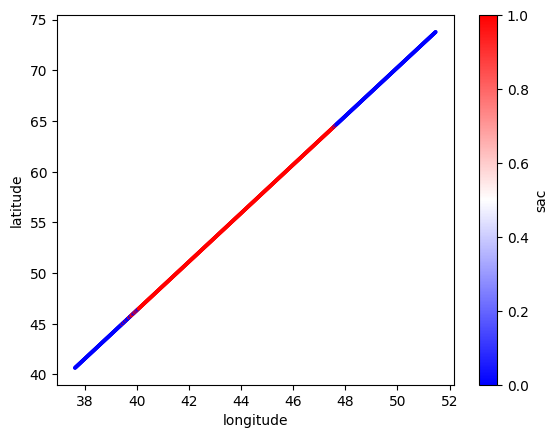

In [86]:
def get_intervals_with_calculations(p, q1, q2, q3):
    intervals = {}
    interval_values_p = []
    interval_values_q1 = []
    interval_values_q2 = []
    interval_values_q3 = []
    interval_count = 1

    for i in range(len(p)):
        if p[i] != 0:
            # Collect values from each list
            interval_values_p.append(p[i])
            interval_values_q1.append(q1[i])
            interval_values_q2.append(q2[i])
            interval_values_q3.append(q3[i])
        else:
            if len(interval_values_p) > 2:  # Process the interval if non-empty
                # Calculate sum of p values
                sum_p = sum(interval_values_p)

                # Calculate the absolute difference in q1 and q2, and multiply by 110000
                max_diff_q1 = max(interval_values_q1) - min(interval_values_q1)
                max_diff_q2 = max(interval_values_q2) - min(interval_values_q2)

                max_diff_q3 = abs(max(interval_values_q3) - min(interval_values_q3))
                mod_diff_q1_q2 = abs(max_diff_q1) * 110
                mod_diff_q2_q2 = abs(max_diff_q2) * 110


                # Calculate the Pythagorean theorem result
                pythagorean_result = math.sqrt(mod_diff_q1_q2**2 + mod_diff_q2_q2**2)
                # Sum of EF by contrails divided by the total fuel energy forcing to know the ratio of difference
                ratio_ef = sum_p / distance / CO2_ef_per_flight_m
                # CO2 burned during the contrail period
                before = pythagorean_result*kgs_fuel_burn_per_km*T_co2_per_kg
                # Reroute is calculated simply on the hypothenuse of the first and last waypoint latitude
                reroute = abs(interval_values_q1[1]-interval_values_q1[0])*math.sqrt(2)*110 + abs(interval_values_q1[-1]-interval_values_q1[-2])*math.sqrt(2)*110
                # CO2 rerouting would emit
                CO2_reroute = reroute*kgs_fuel_burn_per_km*T_co2_per_kg
                # Price in dollars of fuel burned for rerouting
                p_reroute = reroute*kgs_fuel_burn_per_km*cost_of_fuel_per_kg


                # Store in intervals dictionary
                # CO2 net value after reroute is CO2 equivalent from EF generated by contrails compared to CO2 generated by
                intervals[f'Data of Contrail {interval_count}'] = {
                    "cost to reroute": p_reroute,
                    "contrail impact compared to flight's CO2": ratio_ef,
                    "CO2 emissions and equivalent before reroute": before+before*ratio_ef,
                    "CO2 emissions and equivalent after reroute": before+CO2_reroute,
                    "Possible Carbon Credits": before*ratio_ef-CO2_reroute
                }

                # Reset interval lists and increment interval count
                interval_values_p = []
                interval_values_q1 = []
                interval_values_q2 = []
                interval_values_q3 = []
                interval_count += 1
    return [intervals, interval_count]

# Check if API_URL_BASE is already set, otherwise set it.
if "API_URL_BASE" not in os.environ:
    os.environ["API_URL_BASE"] = "https://api.contrails.org/v0"
    print("API_URL_BASE environment variable set.")
else:
    print("API_URL_BASE environment variable already exists.")

def get_corresponding_values(p, q):
    return [q[i] for i in range(len(p)) if p[i] != 0]

# Retrieve API_URL_BASE after setting it
URL = os.environ["API_URL_BASE"]

# Check if CONTRAILS_API_KEY is already set, otherwise set it (Optional but recommended).
if "CONTRAILS_API_KEY" not in os.environ:
    os.environ["CONTRAILS_API_KEY"] = "e760d484e45ea402ff286abee0984e33"
    print("CONTRAILS_API_KEY environment variable set.")
else:
    print("CONTRAILS_API_KEY environment variable")

api_key = os.environ["CONTRAILS_API_KEY"]
headers = {"x-api-key": api_key}

r = requests.post(f"{URL}/trajectory/sac", json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")

r_json = r.json()
for k, v in r_json.items():
    print(f"{k}: {v}")

flight_df = pd.DataFrame(flight).assign(sac=r_json["sac"])
flight_df.plot.scatter(x="longitude", y="latitude", c="sac", cmap="bwr", s=3);

HTTP Response Code: 200 OK

cocip_max_contrail_age: 12 hours
cocip_dt_integration: 10 minutes
flight_id: 1728242557727461
met_source_provider: ECMWF
met_source_dataset: HRES
met_source_product: forecast
met_source_forecast_time: 2024-10-06T12:00:00Z
pycontrails_version: 0.52.1
nvpm_data_source: ICAO EDB
engine_uid: 04P10IA027
humidity_scaling_name: histogram_matching
humidity_scaling_formula: era5_quantiles -> iagos_quantiles
sac: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
nox_ei: [0.0236, 0.0236, 0.0236, 0.0236, 0.0237, 0.0237, 0.0237, 0.0237, 0.0237, 0.02...
nvpm_ei_n: [726000000000000.0, 726000000000000.0, 726000000000000.0, 726000000000000.0, ...
energy_forcing: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
contrail_age: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
initially_persistent: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...
{'cost t

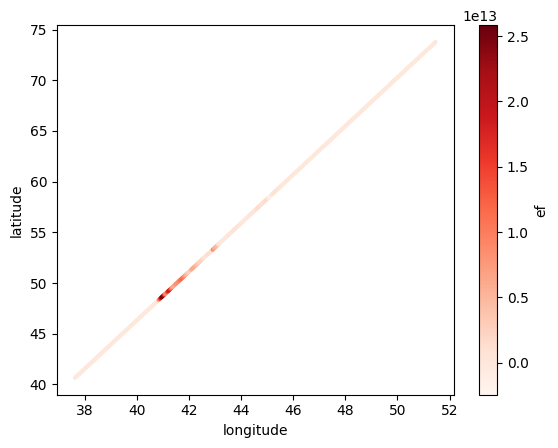

In [87]:
r = requests.post(f"{URL}/trajectory/cocip", json=flight, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}\n")
r_json = r.json()

# The /trajectory/cocip endpoint includes many fields in the response.
for k, v in r_json.items():
    v = str(v)
    if len(v) > 80:
        v = v[:77] + "..."
    print(f"{k}: {v}")

# Energy forcing is the primary model output.
ef = np.array(r_json["energy_forcing"], dtype=float)
response = get_intervals_with_calculations(ef, flight["longitude"], flight["latitude"], flight["aircraft_mass"])
interval_count = response[1]
df = response[0]
for i in range(interval_count):
  try:
    print(df[f'Data of Contrail {i+1}'])
    print("\n")
  except:
    pass
flight_df["ef"] = ef
print(flight_df)
flight_df.plot.scatter(x="longitude", y="latitude", c="ef", cmap="Reds", s=3);

HTTP Response Code: 200 OK
HTTP Response Code: 200 OK


,longitude,latitude,altitude,time,tau_cirrus,tau_contrail,rf_sw,rf_lw,width,depth,segment_length,n_ice_per_m,r_ice_vol
0,14.345,58.069,34862.0,2024-10-07 01:40:00,0.0000,0.2203,0.0,2.286,63.0,86.0,0.0,7.404000e+12,4.740000e-07
0,14.428,58.203,34836.0,2024-10-07 01:50:00,0.0001,0.0311,0.0,0.317,417.0,121.0,4014.0,7.332000e+12,4.640000e-07
0,14.427,58.239,34836.0,2024-10-07 01:50:00,0.0010,0.0668,0.0,0.927,392.0,120.0,4004.0,7.199000e+12,6.460000e-07
0,14.427,58.275,34839.0,2024-10-07 01:50:00,0.0019,0.0877,0.0,1.397,365.0,119.0,4004.0,7.459000e+12,7.550000e-07
1,14.521,58.266,34806.0,2024-10-07 02:00:00,0.0015,0.0179,0.0,0.195,835.0,158.0,4056.0,7.187000e+12,4.930000e-07


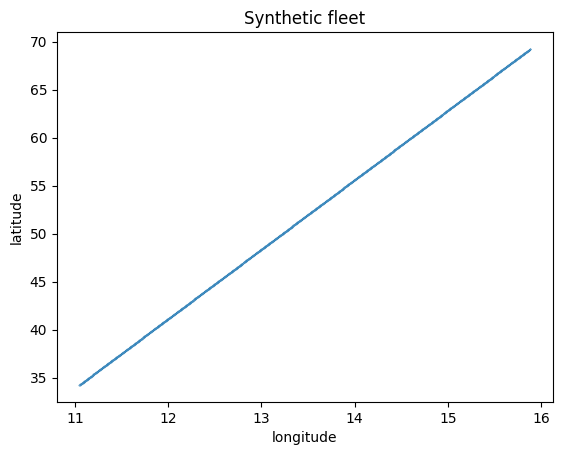

In [88]:
fl = pd.DataFrame()
fl["longitude"] = np.linspace(10, 15, n_waypoints)
fl["latitude"] = np.linspace(35, 65, n_waypoints)
fl["altitude"] = 37000.0
fl["time"] = pd.date_range(t0, t1, periods=n_waypoints).astype(int) // 1_000_000_000

rng = np.random.default_rng(5772156)
fls = []
lon0, lon1, lat0, lat1 = rng.uniform(-5, 5, 4)
fl_perturb = fl.copy()
fl_perturb["longitude"] += np.linspace(lon0, lon1, len(fl_perturb))
fl_perturb["latitude"] += np.linspace(lat0, lat1, len(fl_perturb))
fl_id = 1
fl_perturb["flight_id"] = f"{fl_id:2d}"
fl_perturb["time"] += rng.integers(0, 7200)
fl_perturb["altitude"] += rng.choice([-2000, 0, 2000])
fl_perturb["aircraft_type"] = rng.choice(["A320", "B737"])
fls.append(fl_perturb)
fleet = pd.concat(fls)

# Visualize our synthetic fleet
fleet.plot.scatter("longitude", "latitude", s=0.1, title="Synthetic fleet");

payload = fl.to_dict("list") | {"aircraft_type": "B752"}

r = requests.post(f"{URL}/trajectory/cocip-contrail", json=payload, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")
r_json = r.json()

payload = fleet.to_dict("list")

r = requests.post(f"{URL}/trajectory/cocip-contrail", json=payload, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

r_json = r.json()
contrail = pd.concat([pd.DataFrame(c) for c in r_json["contrail"]])
contrail["time"] = pd.to_datetime(contrail["time"], unit="s")

# Convert contrail data in response to a pd.DataFrame

contrail = pd.concat([pd.DataFrame(c) for c in r_json["contrail"]])

# The time field has the same format as the request time.
contrail["time"] = pd.to_datetime(contrail["time"], unit="s")
contrail.head(5)

............................................................

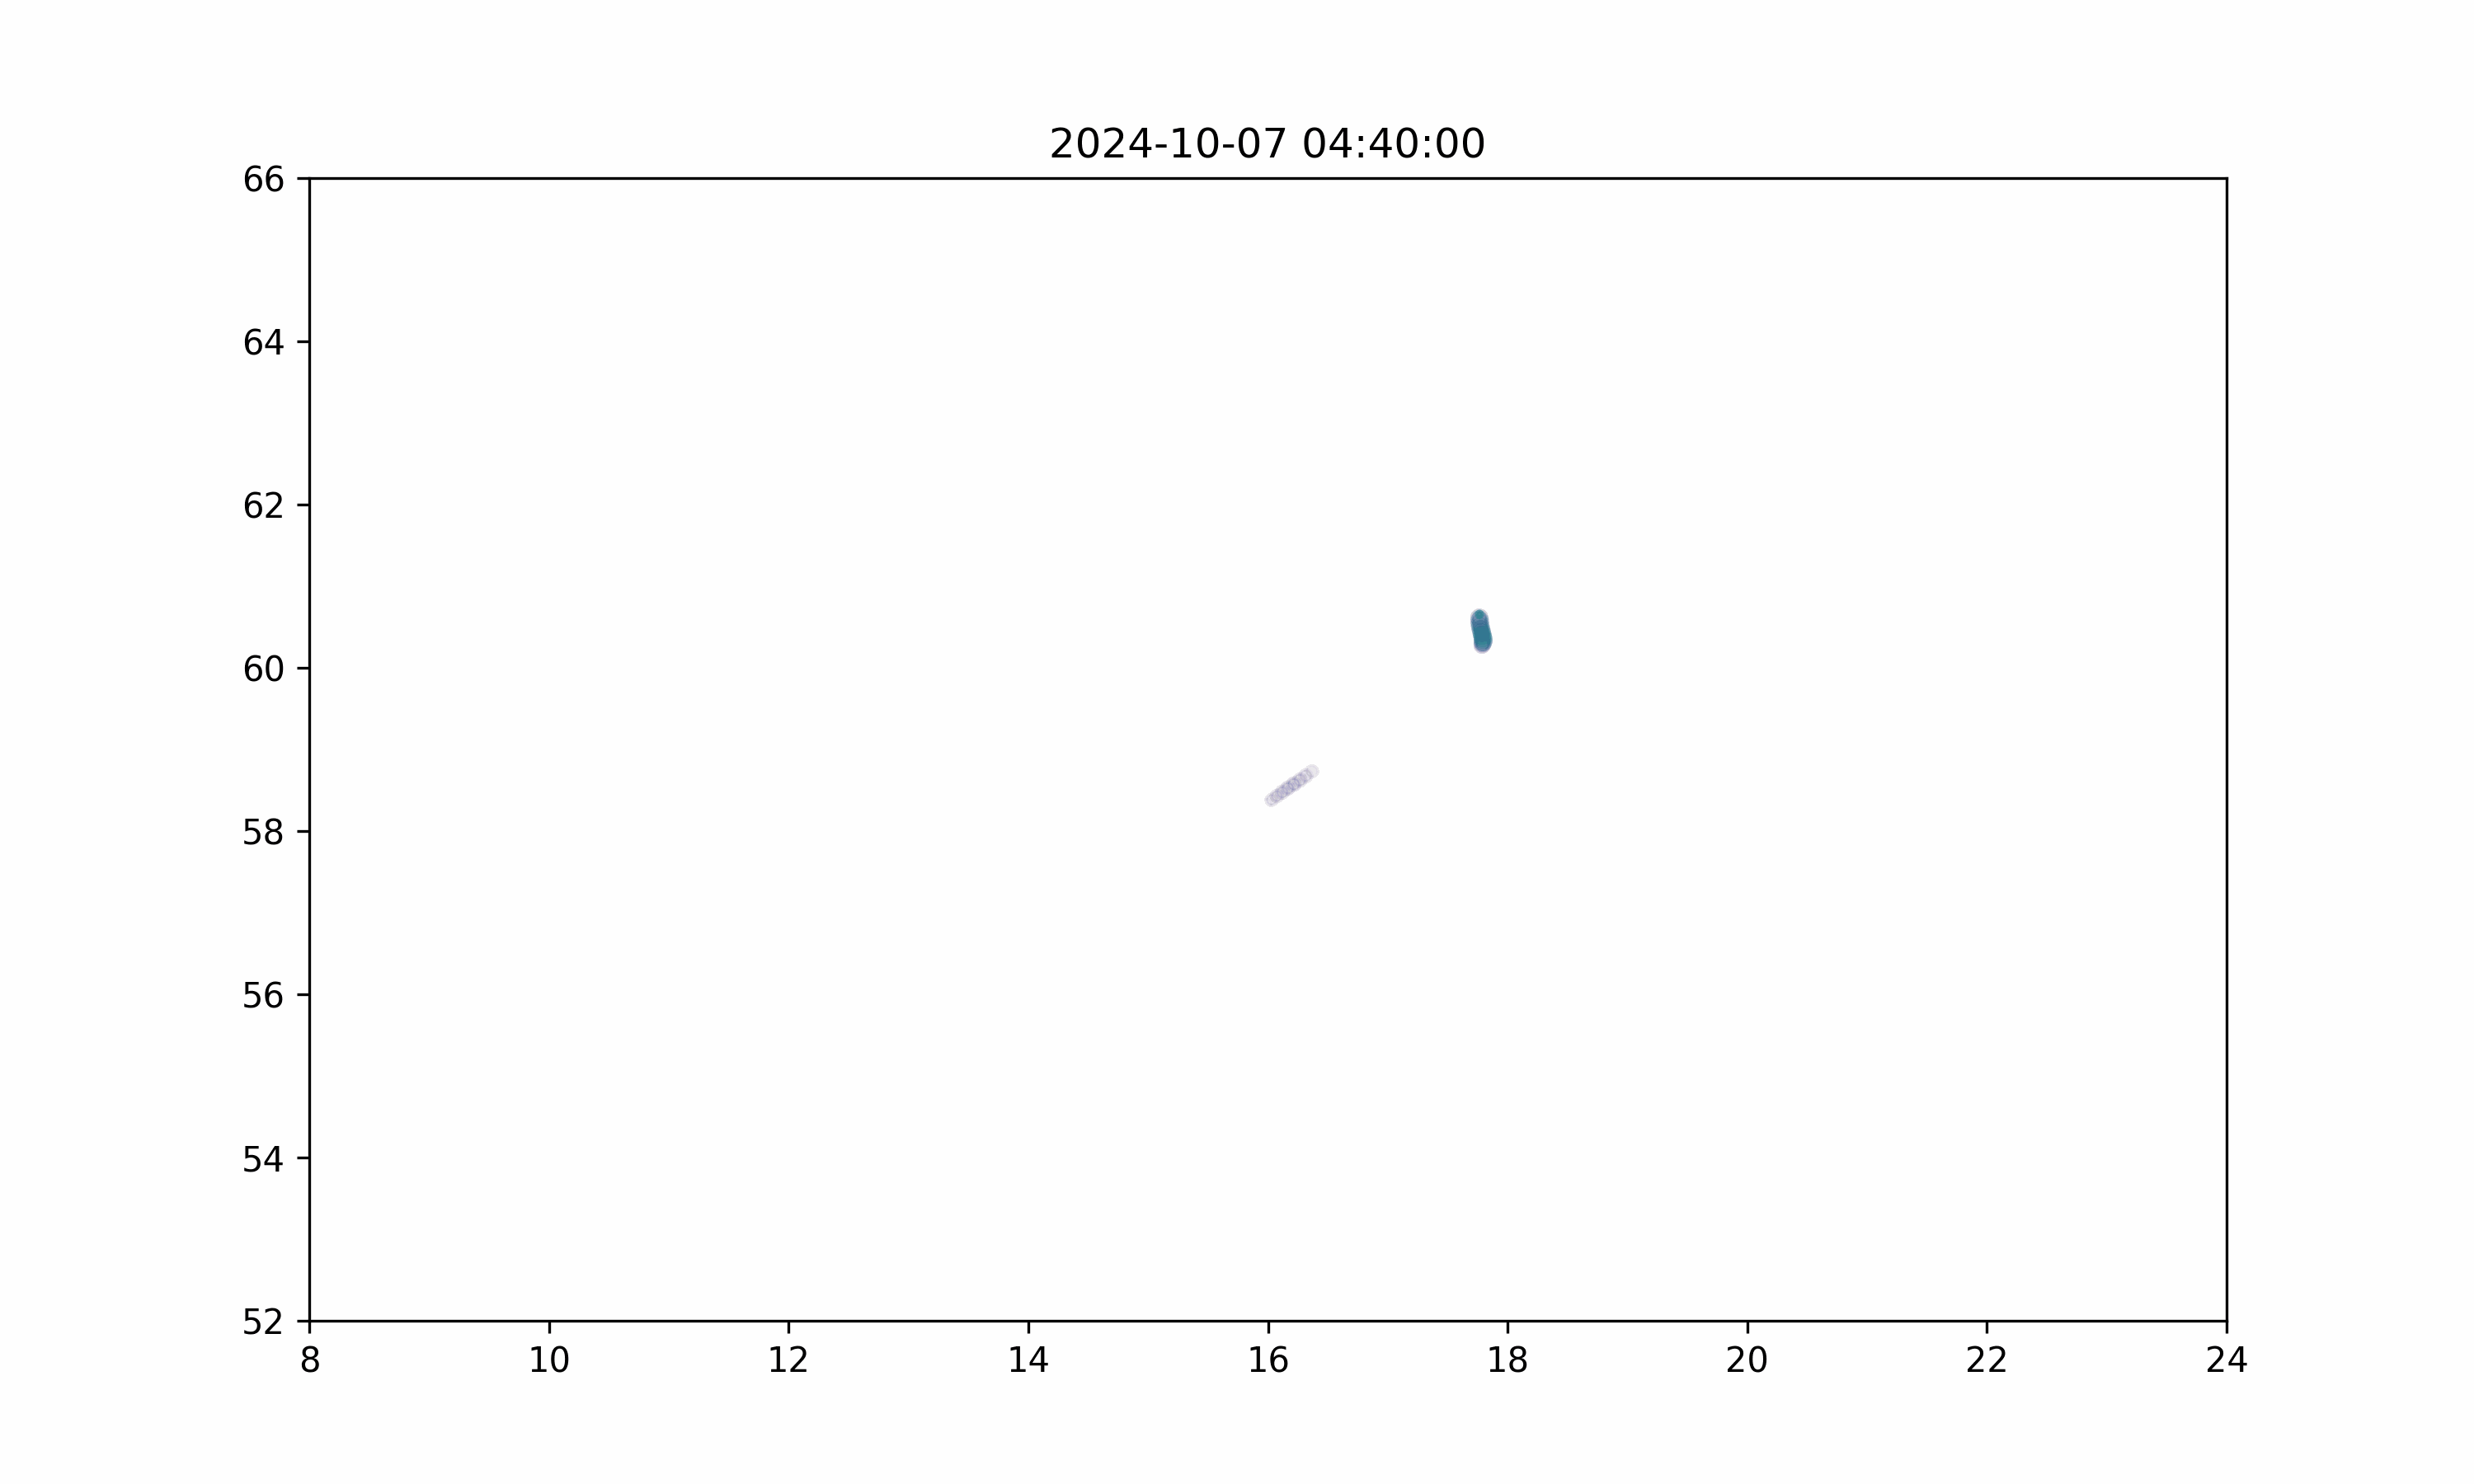

.

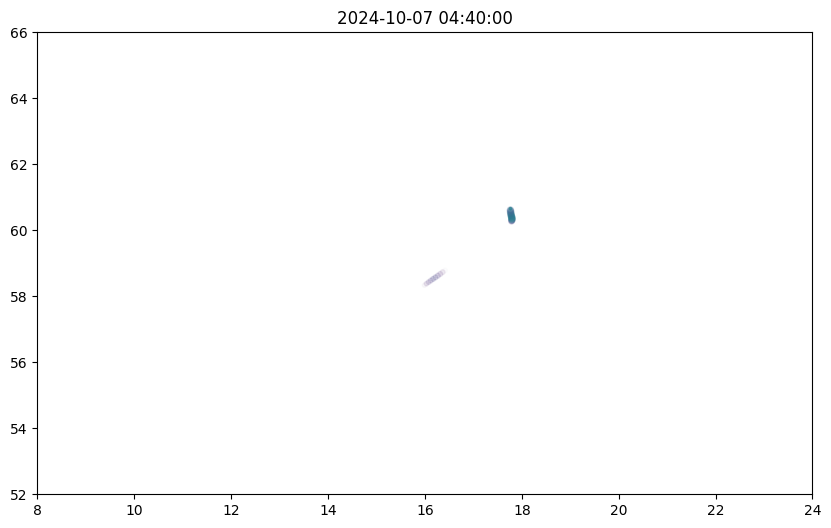

In [89]:
fleet = fleet.set_index(pd.to_datetime(fleet["time"], unit="s").dt.floor("1min"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(8, 24)
ax.set_ylim(52, 66)

scat1 = ax.scatter([], [], s=2, color="red")
scat2 = ax.scatter([], [], c=[], vmin=0, vmax=20)

filt = (
    contrail["longitude"].between(8, 24)
    & contrail["latitude"].between(52, 66)
    & contrail["time"].between(t1, td)
)
contrail_filt = contrail[filt]
frames = contrail_filt.groupby("time")

def animate(frame):
    print(".", end="")  # progress bar
    time, group = frame
    ax.set_title(time)

    try:
        scat1.set_offsets(fleet.loc[time, ["longitude", "latitude"]])
    except KeyError:
        scat1.set_offsets([[None, None]])

    scat2.set_offsets(group[["longitude", "latitude"]])
    scat2.set_alpha((3 * group["tau_contrail"]).clip(upper=1))
    scat2.set_array(group["rf_lw"])
    scat2.set_sizes(group["width"].clip(upper=20000) / 1000)

    return scat1, scat2

# Create the animation
ani = FuncAnimation(fig, animate, frames=frames)
ani.save("evo.gif", dpi=300, writer=PillowWriter(fps=2))

with open("evo.gif", "rb") as f:
    display(Image(data=f.read(), format="png"))

# Cleanup
os.remove("evo.gif")


https://www.sciencedirect.com/science/article/pii/S1352231020305689?via%3Dihub#sec7



In [90]:
params = {
    "time": t0,
    "aircraft_type": "A321",
    "threshold": 0,
    "format": "geojson",
    "flight_level": 360,
    "bbox": bbox,
    "interiors": True,
}
r = requests.get(f"{URL}/grid/cocip", params=params, headers=headers)
print(f"HTTP Response Code: {r.status_code} {r.reason}")

geojson = r.json()
print(r.json())
feature = geojson["features"][0]

# Print out the metadata
pprint(feature["properties"])

# Convert the output to shapely
# Unfortunately, GEOS can't handle the altitude coordinate returned by the API
# Manually loop through and remove it
for coords in feature["geometry"]["coordinates"]:
    for poly in coords:
        for point in poly:
            del point[2]

multipoly = shapely.from_geojson(json.dumps(feature))

for poly in multipoly.geoms:
    plt.plot(*poly.exterior.xy, color="red", lw=1)
    for interior in poly.interiors:
        plt.plot(*interior.xy, color="blue", lw=1)

# Print some statistics on the polygons
n_exterior_rings = len(multipoly.geoms)
n_interior_rings = sum(len(p.interiors) for p in multipoly.geoms)
n_exterior_vertices = sum(len(p.exterior.coords) for p in multipoly.geoms)
n_interior_vertices = sum(len(i.coords) for p in multipoly.geoms for i in p.interiors)
area = multipoly.area

print(f"Number of exterior rings: {n_exterior_rings}")
print(f"Number of interior rings: {n_interior_rings}")
print(f"Number of exterior vertices: {n_exterior_vertices}")
print(f"Number of interior vertices: {n_interior_vertices}")
print(f"Total area: {area}")  # units are in the image of the Plate carree projection

# Formalize some of cells above into functions for later use


def get_shapely(**kwargs):
    params = {
        "time": "2023-02-10",
        "aircraft_type": "B789",
        "threshold": 0,
        "format": "geojson",
        "flight_level": 360,
    }
    params.update(kwargs)

    r = requests.get(f"{URL}/grid/cocip", params=params, headers=headers)
    r.raise_for_status()

    geojson = r.json()
    (feature,) = geojson["features"]

    for coords in feature["geometry"]["coordinates"]:
        for poly in coords:
            for point in poly:
                del point[2]

    return shapely.from_geojson(json.dumps(feature))


def polygon_metrics(multipoly):
    n_exterior_rings = len(multipoly.geoms)
    n_interior_rings = sum(len(p.interiors) for p in multipoly.geoms)
    n_exterior_vertices = sum(len(p.exterior.coords) for p in multipoly.geoms)
    n_interior_vertices = sum(len(i.coords) for p in multipoly.geoms for i in p.interiors)
    area = multipoly.area
    return {
        "n_exterior_rings": n_exterior_rings,
        "n_interior_rings": n_interior_rings,
        "n_exterior_vertices": n_exterior_vertices,
        "n_interior_vertices": n_interior_vertices,
        "area": area,
    }

multipoly = get_shapely(interiors=False)

print(polygon_metrics(multipoly))

for poly in multipoly.geoms:
    plt.plot(*poly.exterior.xy, color="red", lw=1)
    assert len(poly.interiors) == 0


HTTP Response Code: 422 unknown
{'detail': {'msg': "Malformed bounding box ('bbox') parameter.", 'reason': 'bbox coordinate order is E,S,W,N'}}


KeyError: 'features'

In [ ]:
# prompt: Take the plot above, calculate multiple versions of it for every possible flight level, and put on top of eachother to make a 3d plot. Keep the original colours from the level. Also, I want for the plot to be shown as a polygon, connecting the surfaces, not as different layers. The color should change with the value, if it's negative, blue, positive, red, and change tones.

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import requests
import json
import shapely.geometry as sgeom
import shapely

# Assuming you have the necessary functions and variables defined from the preceding code
# (get_shapely, polygon_metrics, URL, headers, etc.)

def plot_polygon_3d(ax, multipoly, flight_level, color):
    """Plots a polygon in 3D space."""
    for poly in multipoly.geoms:
        exterior_coords = np.array(list(poly.exterior.coords))
        xs = exterior_coords[:, 0]
        ys = exterior_coords[:, 1]
        zs = np.full_like(xs, flight_level)
        ax.plot_trisurf(xs, ys, zs, color=color, alpha=0.7)

# Create a 3D figure and axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Range of flight levels you want to plot
flight_levels = range(350, 380, 5)

for flight_level in flight_levels:
  multipoly = get_shapely(flight_level=flight_level, interiors=False)
  for polygon in multipoly.geoms:
    try:

        print(polygon.coords)
        # Determine the color based on the ef of the polygon
        """if polygon.coords  < 0:
            color = "blue"  # Negative area, blue color
        else:
            color = "red"  # Positive area, red color
"""
        plot_polygon_3d(ax, multipoly, flight_level, bl)
    except Exception as e:
        print(f"Error processing flight level {flight_level}: {e}")


# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Flight Level")
ax.set_title("3D Plot of Contrail Impacts at Different Flight Levels")

# Adjust view angle
ax.view_init(elev=30, azim=45)

# Display the plot
plt.show()
